In [ ]:
!pip install kaggle

In [6]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
zip_path = '/content/drive/MyDrive/datas.zip'
extract_path = '/content/dataset/'

# Extract dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def preprocess_data(data_path, image_size):
    X = []
    y = []

    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, image_size)
            X.append(image)
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    return X, y_categorical

# Define data paths
train_data_path = '/content/dataset/train/'
test_data_path = '/content/dataset/test/'

# Preprocess train and test data
image_size = (48, 48)
X_train, y_train = preprocess_data(train_data_path, image_size)
X_test, y_test = preprocess_data(test_data_path, image_size)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data for CNN input
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
898/898 [==============================] - 113s 122ms/step - loss: 1.7225 - accuracy: 0.3055 - val_loss: 1.5472 - val_accuracy: 0.4069
Epoch 2/20
898/898 [==============================] - 95s 106ms/step - loss: 1.4911 - accuracy: 0.4271 - val_loss: 1.3914 - val_accuracy: 0.4681
Epoch 3/20
898/898 [==============================] - 90s 100ms/step - loss: 1.3786 - accuracy: 0.4729 - val_loss: 1.2957 - val_accuracy: 0.5070
Epoch 4/20
898/898 [==============================] - 94s 105ms/step - loss: 1.3000 - accuracy: 0.5082 - val_loss: 1.2476 - val_accuracy: 0.5233
Epoch 5/20
898/898 [==============================] - 91s 101ms/step - loss: 1.2383 - accuracy: 0.5311 - val_loss: 1.2209 - val_accuracy: 0.5368
Epoch 6/20
898/898 [==============================] - 92s 102ms/step - loss: 1.1994 - accuracy: 0.5441 - val_loss: 1.2025 - val_accuracy: 0.5372
Epoch 7/20
898/898 [==============================] - 95s 106ms/step - loss: 1.1565 - accuracy: 0.5639 - val_loss: 1.1830 - val_a

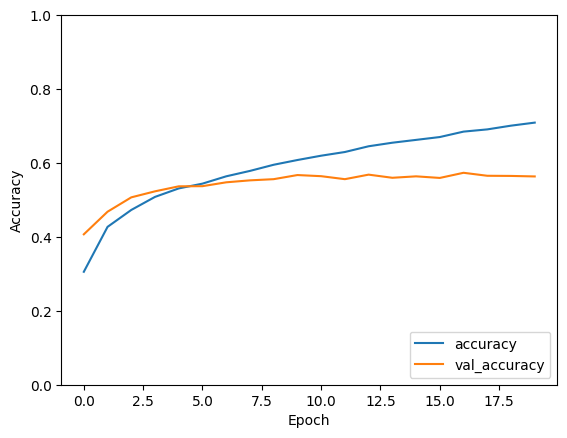

225/225 [==============================] - 5s 24ms/step - loss: 1.3763 - accuracy: 0.5635
Test Loss: 1.3762884140014648
Test Accuracy: 0.5635274648666382


In [9]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

In [10]:
# Define model path
import os
current_directory = os.getcwd()
model_path = os.path.join(current_directory, 'facial_expression_model')

# Save the model
model.save(model_path)

In [13]:
import cv2
import numpy as np
import os

# Load pre-trained model
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define model path
import os
current_directory = os.getcwd()
model_path = os.path.join(current_directory, 'facial_expression_model')

# Load the model
model = load_model(model_path)

# Define emotion labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Perform real-time facial expression recognition
def predict_emotion(frame):
    # Preprocess frame
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame_resized = cv2.resize(frame_gray, (48, 48))
    frame_normalized = frame_resized.astype('float32') / 255.0
    frame_input = np.expand_dims(frame_normalized, axis=0)
    frame_input = np.expand_dims(frame_input, axis=-1)

    # Perform emotion prediction using the loaded model
    prediction = model.predict(frame_input)
    predicted_class = np.argmax(prediction)
    predicted_emotion = emotion_labels[predicted_class]

    return predicted_emotion

# Initialize video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Perform facial expression recognition
    predicted_emotion = predict_emotion(frame)

    # Display predicted emotion on frame
    cv2.putText(frame, predicted_emotion, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display frame
    cv2.imshow('Facial Expression Recognition', frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video capture and close OpenCV windows
cap.release()
cv2.destroyAllWindows()
